This notebook seeks to investigate the correlation between trends (continuous growth over time) and product sales.

In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, PercentFormatter
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

In [83]:
all_transactions = pd.read_parquet('../../../data/transactions_train.parquet')
articles = pd.read_parquet('../../../data/articles.parquet')
customers = pd.read_parquet('../../../data/customers.parquet')

In [84]:
# For every product, group the purchases per week (count is amount of rows)
purchases_per_week = all_transactions.groupby(['article_id', 'week']).size().reset_index(name='count')
purchases_per_week

,article_id,week,count
0,108775015,0,224
1,108775015,1,523
2,108775015,2,305
3,108775015,3,342
4,108775015,4,293
...,...,...,...
2201226,953450001,104,5
2201227,953763001,103,17
2201228,953763001,104,18
2201229,956217002,103,13


In [85]:
purchases_per_week["growth"] = purchases_per_week.groupby(['article_id'])['count'].pct_change()
purchases_per_week

,article_id,week,count,growth
0,108775015,0,224,NaN
1,108775015,1,523,1.334821
2,108775015,2,305,-0.416826
3,108775015,3,342,0.121311
4,108775015,4,293,-0.143275
...,...,...,...,...
2201226,953450001,104,5,-0.500000
2201227,953763001,103,17,NaN
2201228,953763001,104,18,0.058824
2201229,956217002,103,13,NaN


In [86]:
# def plot_article_growth(article_id):
#     # Plot growth of the article as bar chart from week 0 to max week, color is green if growth is positive, red if negative
#     article_purchases = purchases_per_week[purchases_per_week['article_id'] == article_id]
#     
#     
#     #Set domain to 0 to max week
#     article_purchases = article_purchases.set_index('week')
#     article_purchases = article_purchases.reindex(range(0, article_purchases.index.max() + 1))
#     article_purchases = article_purchases.reset_index()
#     
#     plt.figure(figsize=(20, 10))
#     
#     article_purchases['growth'].plot.bar(color=article_purchases['growth'].apply(lambda x: 'g' if x > 0 else 'r'))
#     plt.title(f'Article {article_id}')
#     plt.xlabel('Week')
#     plt.ylabel('Growth')
#     
#     plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#     
#     plt.show()


# Plot the article growth and sales count in one graph
def plot_article_growth(article_id):
    # Plot growth of the article as bar chart from week 0 to max week, color is green if growth is positive, red if negative
    article_purchases = purchases_per_week[purchases_per_week['article_id'] == article_id]
    
    #Set domain to 0 to max week
    article_purchases = article_purchases.set_index('week')
    article_purchases = article_purchases.reindex(range(0, article_purchases.index.max() + 1))
    article_purchases = article_purchases.reset_index()
    
    plt.figure(figsize=(20, 10))
    
    ax = plt.gca()
    ax2 = ax.twinx()
    
    article_purchases['count'].plot(color='b', ax=ax2, alpha=0.5, linewidth=5) 
    article_purchases['growth'].plot.bar(color=article_purchases['growth'].apply(lambda x: 'g' if x > 0 else 'r'), ax=ax)
    
    ax.set_title(f'Article {article_id}')
    ax.set_xlabel('Week')
    ax.set_ylabel('Growth')
    ax2.set_ylabel('Sales count')
    
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    
    plt.show()

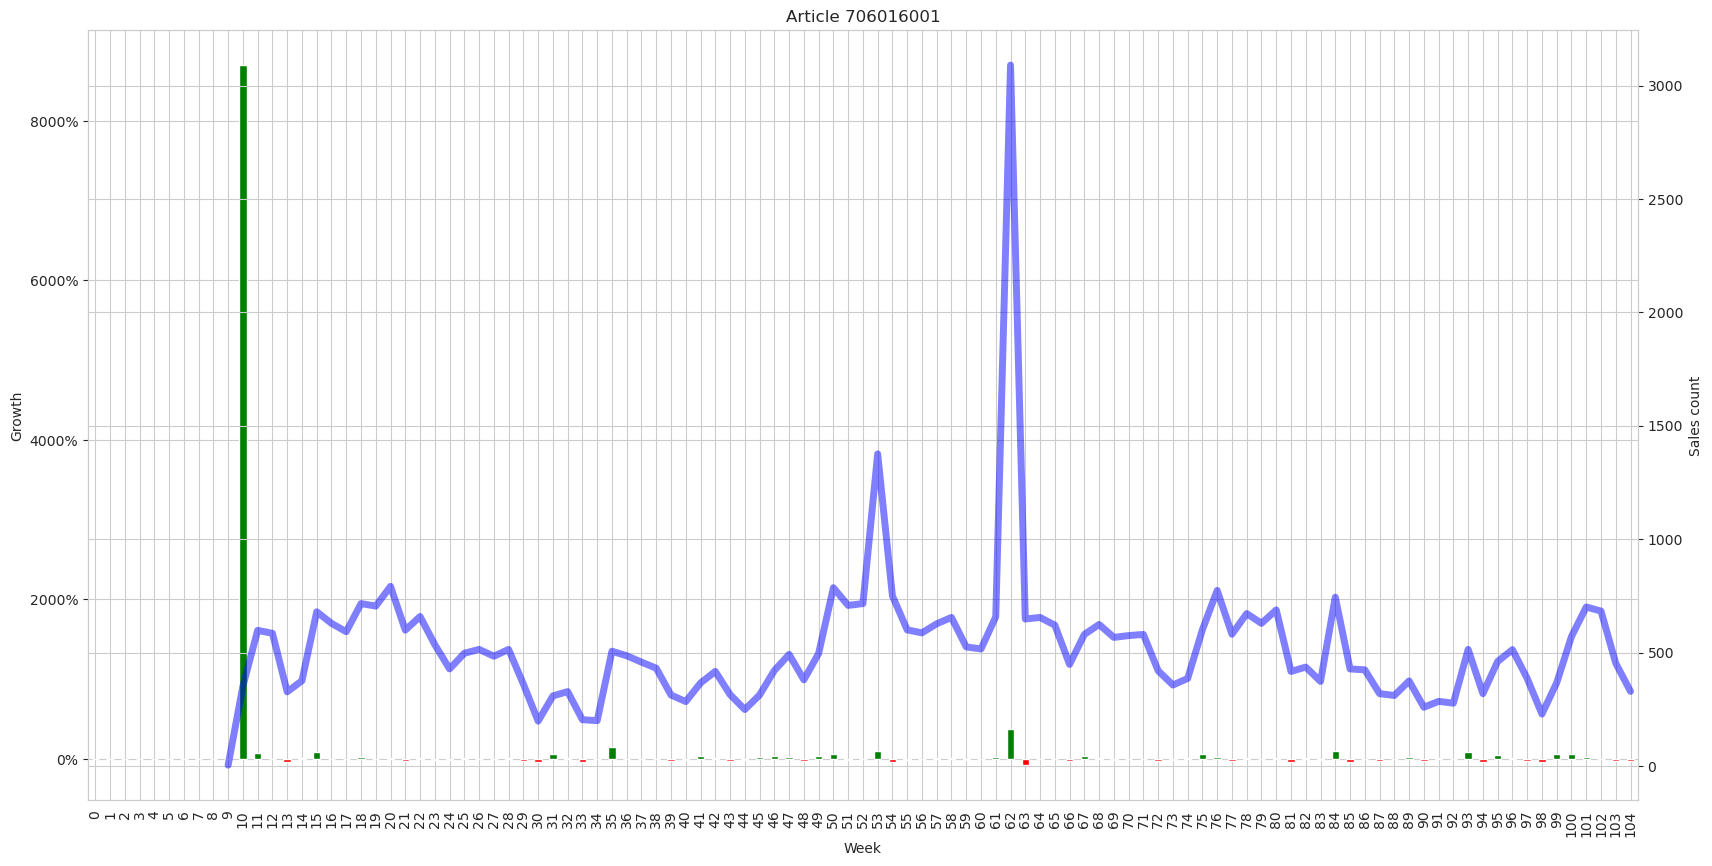

In [87]:
# Select random article to plot with more than 10000 purchases
plot_article_growth(all_transactions['article_id'].value_counts()[all_transactions['article_id'].value_counts() > 50000].sample().index[0])

In [88]:
# List articles with more than 10000 purchases
all_transactions['article_id'].value_counts()

article_id
706016001    50287
706016002    35043
372860001    31718
610776002    30199
759871002    26329
             ...  
390531007        1
734529007        1
653907001        1
456641003        1
880582004        1
Name: count, Length: 104547, dtype: int64

In [94]:
# Determine growth of articles via z-score on i-week sliding window growth
# Normalize the count

i = 2

purchases_per_week['norm_count'] = purchases_per_week.groupby(['article_id'])['count'].transform(lambda x: (x - x.mean()) / x.std())
purchases_per_week['growth'] = purchases_per_week.groupby(['article_id'])['norm_count'].rolling(i).mean().reset_index(0, drop=True)
purchases_per_week['growth_std'] = purchases_per_week.groupby(['article_id'])['norm_count'].rolling(i).std().reset_index(0, drop=True)
purchases_per_week['growth'] = (purchases_per_week['growth'] - purchases_per_week['growth'].mean()) / purchases_per_week['growth_std']
purchases_per_week.drop(columns=['growth_std'], inplace=True)
purchases_per_week


,article_id,week,count,growth,norm_count
0,108775015,0,224,NaN,0.529655
1,108775015,1,523,1.108038,2.354744
2,108775015,2,305,1.782472,1.024077
3,108775015,3,342,7.043045,1.249925
4,108775015,4,293,5.145049,0.950830
...,...,...,...,...,...
2201226,953450001,104,5,0.504553,-0.164957
2201227,953763001,103,17,NaN,-0.707107
2201228,953763001,104,18,-0.012240,0.707107
2201229,956217002,103,13,NaN,0.707107


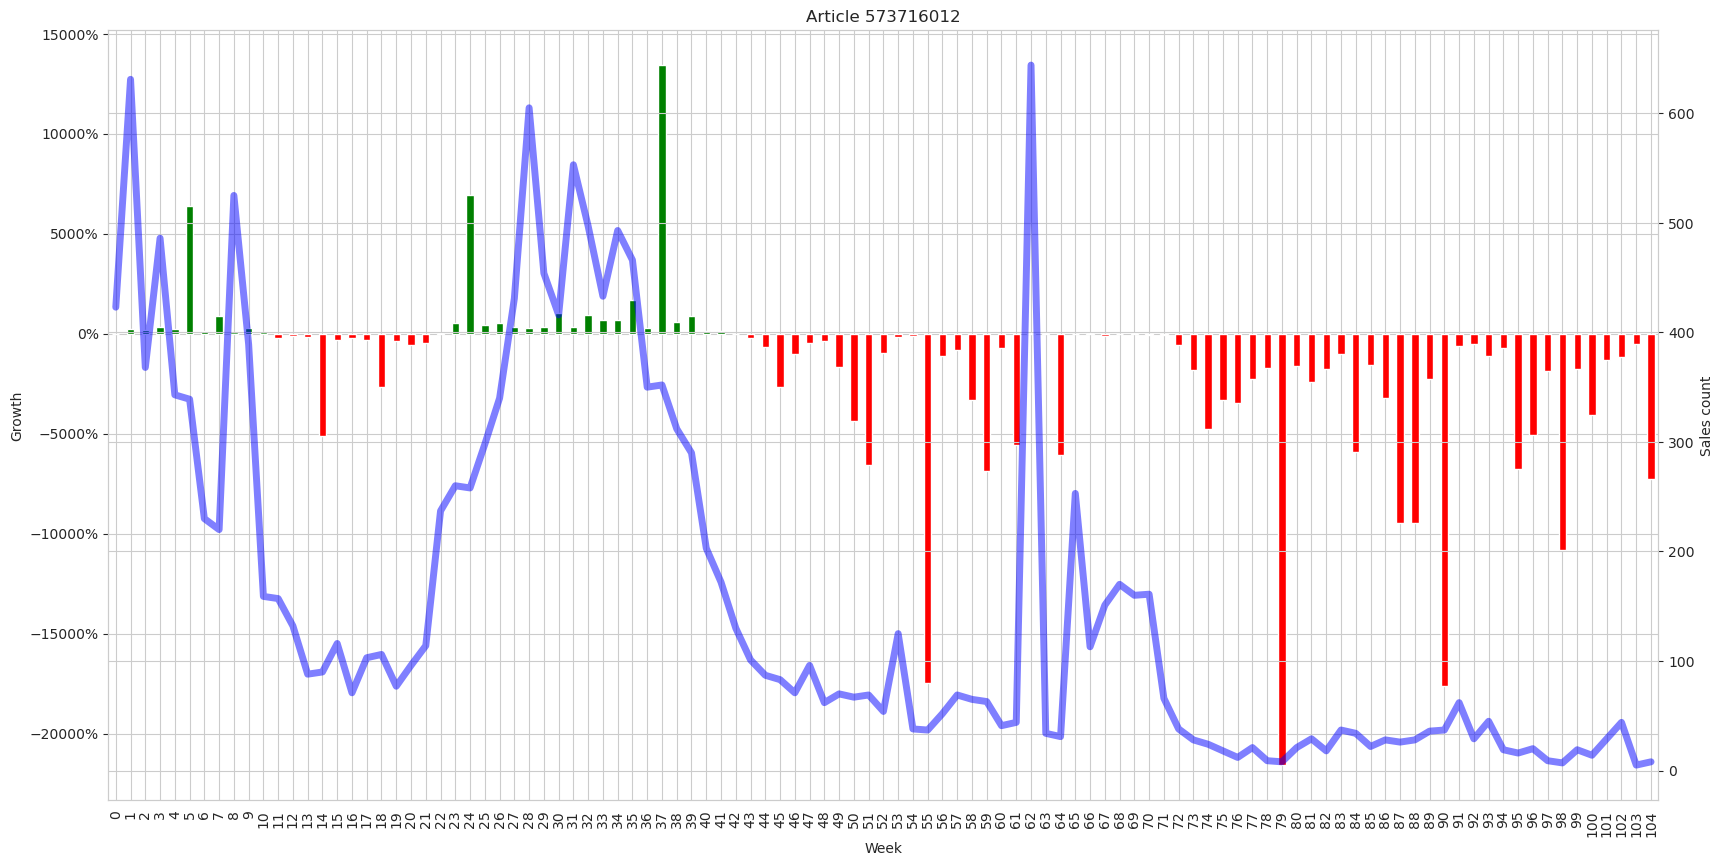

In [91]:
# Plot the growth of an article
plot_article_growth(all_transactions['article_id'].value_counts()[all_transactions['article_id'].value_counts() > 10000].sample().index[0])

In [100]:
# Generate moving average of count per article and predict growth of next week
i = 8
purchases_per_week['count_ma'] = purchases_per_week.groupby(['article_id'])['count'].transform(lambda x: x.rolling(i).mean().shift(-i))
purchases_per_week['growth'] = purchases_per_week.groupby(['article_id'])['count'].pct_change()
purchases_per_week

,article_id,week,count,growth,norm_count,count_ma,growth_ma
0,108775015,0,224,NaN,0.529655,351.250,NaN
1,108775015,1,523,1.334821,2.354744,375.500,-0.218599
2,108775015,2,305,-0.416826,1.024077,370.000,-0.018547
3,108775015,3,342,0.121311,1.249925,371.000,0.138583
4,108775015,4,293,-0.143275,0.950830,369.375,0.113416
...,...,...,...,...,...,...,...
2201226,953450001,104,5,-0.500000,-0.164957,NaN,0.000000
2201227,953763001,103,17,NaN,-0.707107,NaN,NaN
2201228,953763001,104,18,0.058824,0.707107,NaN,NaN
2201229,956217002,103,13,NaN,0.707107,NaN,NaN


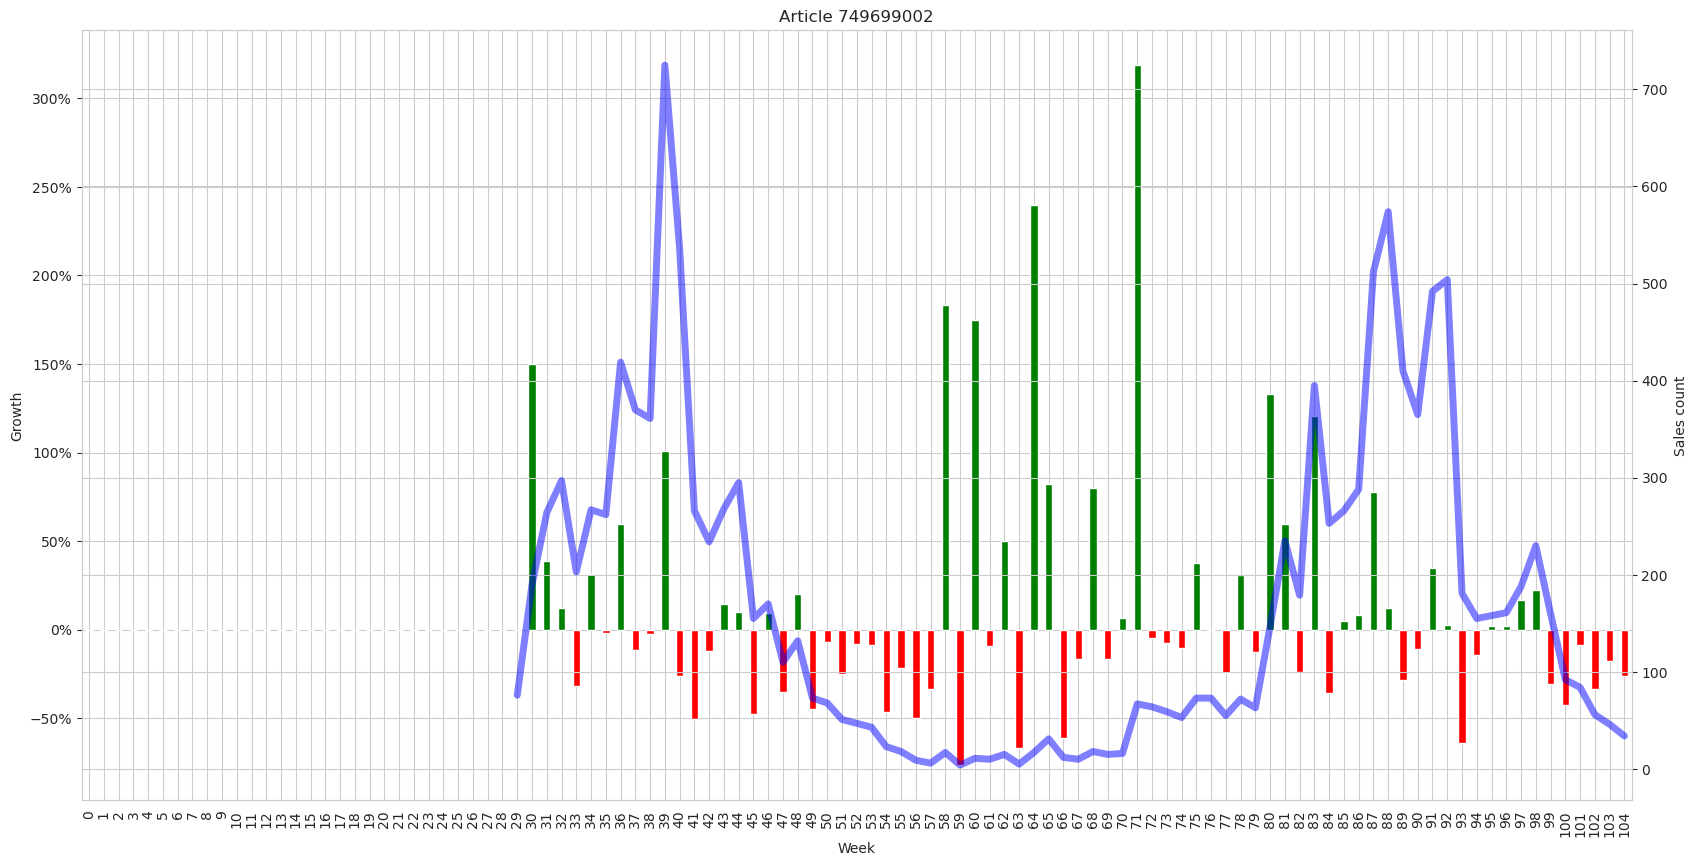

In [105]:
# Plot the growth of an article
plot_article_growth(all_transactions['article_id'].value_counts()[all_transactions['article_id'].value_counts() > 10000].sample().index[0])

In [128]:
# For last week in the dataset, determine whether article is trendy if it has sustained growth for the last i weeks (growth is postive), total amount of articles sold over period must be higher than 500
i = 3
filtered_purchases_per_week = purchases_per_week[purchases_per_week['week'] >= purchases_per_week['week'].max() - i]
filtered_purchases_per_week = filtered_purchases_per_week[filtered_purchases_per_week.groupby(['article_id'])['count'].transform('sum') > 500]
filtered_purchases_per_week = filtered_purchases_per_week[filtered_purchases_per_week.groupby(['article_id'])['growth'].transform(lambda x: (x > 0).all())]
trendy_articles = filtered_purchases_per_week['article_id'].unique()

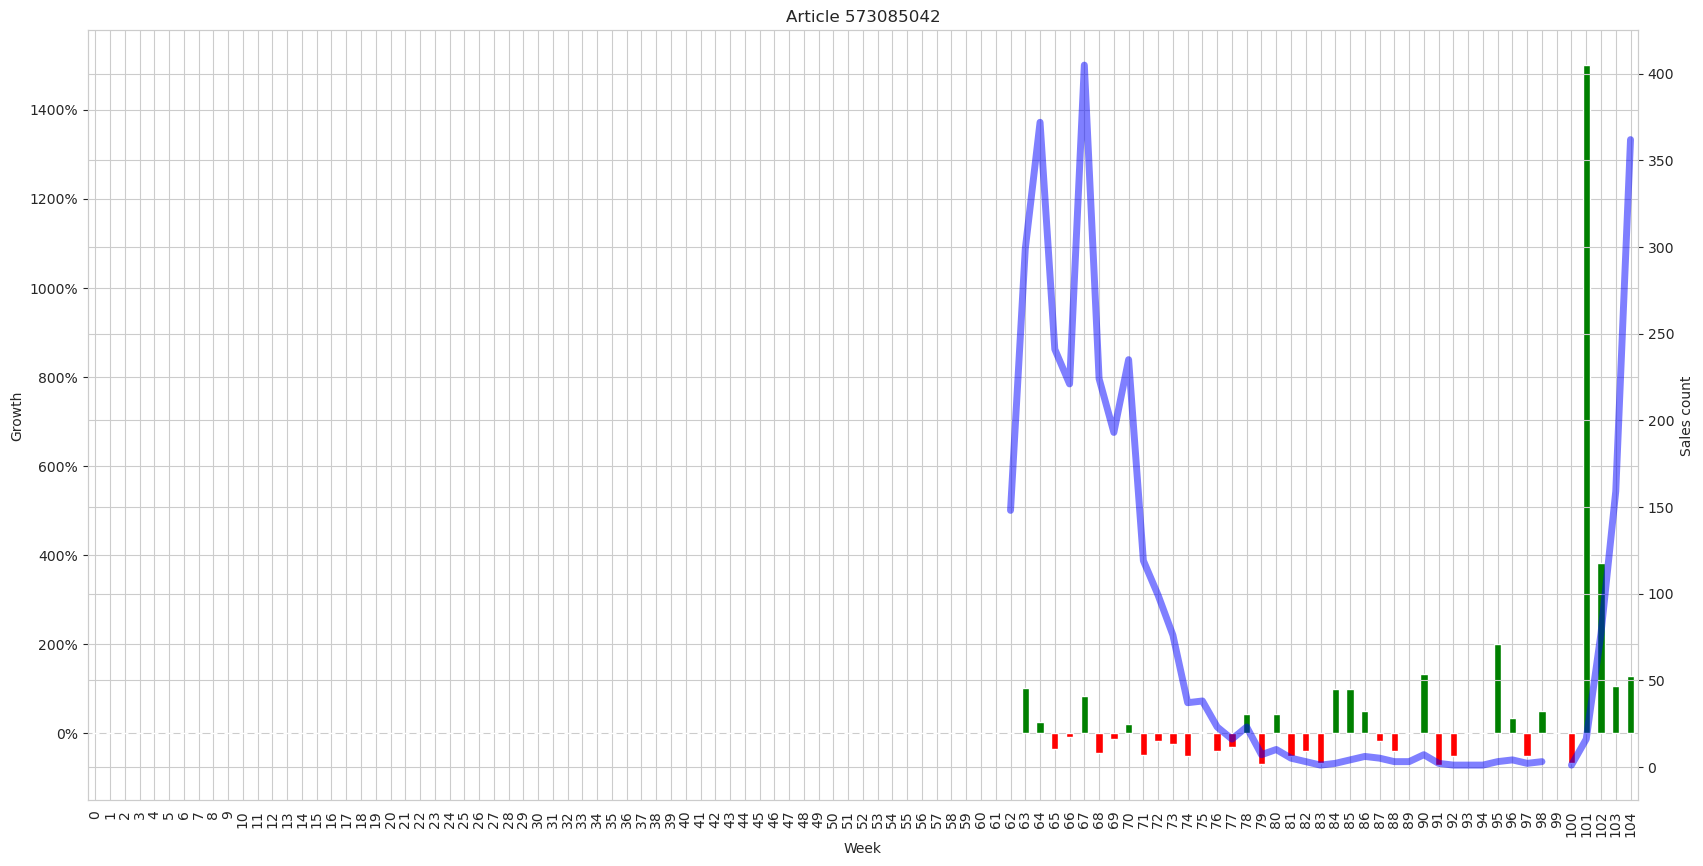

In [132]:
# Plot the growth of an article
plot_article_growth(trendy_articles[np.random.randint(0, len(trendy_articles))])

After investigating different methods for computing growth, the last one seems to generally suit best (after running through multiple articles), though the metric could be improved to use a rolling average or something similar (though it was hard to find a good trade-off between growth reaction speed while still not being too fluctuating. 